In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("combined_B_&_C.csv")

In [3]:
print(df.head())

         date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1  2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2  2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3  2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4  2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   waterfront  view  condition  ...  city_grouped_SeaTac  \
0           0     0          3  ...                False   
1           0     4          5  ...                False   
2           0     0          4  ...                False   
3           0     0          4  ...                False   
4           0     0          4  ...                False   

   city_grouped_Seattle  city_grouped_Shoreline  city_grouped_Snoqualmie  \
0                 False                    True                    False   
1     

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           9200 non-null   object 
 1   price                          9200 non-null   float64
 2   bedrooms                       9200 non-null   float64
 3   bathrooms                      9200 non-null   float64
 4   sqft_living                    9200 non-null   int64  
 5   sqft_lot                       9200 non-null   int64  
 6   floors                         9200 non-null   float64
 7   waterfront                     9200 non-null   int64  
 8   view                           9200 non-null   int64  
 9   condition                      9200 non-null   int64  
 10  sqft_above                     9200 non-null   int64  
 11  sqft_basement                  9200 non-null   int64  
 12  yr_built                       9200 non-null   i

In [5]:
# Replace infinite values with NaN in the entire DataFrame
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# 3. Define target and features
# We use log_price as the target and remove both 'price' and 'log_price' from the features
target_col = 'log_price'
df.dropna(subset=[target_col], inplace=True)  # ensure no missing target values

In [7]:
# 2. Data Cleaning
# Drop non-numeric columns that are not needed for regression
cols_to_drop = ['date', 'street', 'city', 'statezip', 'country', 'bedrooms_bin', 'bathrooms_bin', 'yr_built_bin', 'sqft_living', 'sqft_above', 'sqft_basement']
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [8]:
# Convert boolean columns to integers (0/1)
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [9]:
# 3. Definefeatures

X = df.drop(columns=['price', 'log_price','price_per_sqft'], errors='ignore')
y = df[target_col]

In [10]:
if 'yr_renovated_bin' in X.columns:
    X.drop(columns=['yr_renovated_bin'], inplace=True)

In [11]:
# One-hot encode the floors_bin column if it exists (since it has values like '1', '2', '3+')
if 'floors_bin' in df.columns:
    df = pd.get_dummies(df, columns=['floors_bin'], drop_first=True)

In [12]:
# Optional sanity check
print(X.select_dtypes(exclude='number').columns)

Index(['floors_bin'], dtype='object')


In [13]:
# Just in case, Ensure X contains only numeric columns (drop any remaining non-numeric features)
X = X.select_dtypes(include=[np.number]).copy()

In [14]:
# 4. Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 5. Setup Cross-Validation and scoring metrics
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# Using sklearn's built-in scorers for MAE and RMSE.
scoring = {
    'MAE': 'neg_mean_absolute_error', 
    'RMSE': 'neg_root_mean_squared_error'
}

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

In [17]:
# Custom wrapper for statsmodels OLS to be used in scikit-learn pipelines
class OLSWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, add_constant=True):
        self.add_constant = add_constant

    def fit(self, X, y):
        # Add intercept if required (statsmodels does not add it automatically)
        if self.add_constant:
            X = sm.add_constant(X)
        self.model_ = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        if self.add_constant:
            # Make sure we add the constant if needed during prediction
            # 'has_constant' parameter ensures that a constant column isn’t added twice if it already exists.
            X = sm.add_constant(X, has_constant='add')
        return self.model_.predict(X)

    def summary(self):
        return self.model_.summary()

In [18]:
from sklearn.impute import SimpleImputer
# 6. Build Pipelines for the three models

# (Ordinary Linear Regression)
# ols_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
#    ('reg', LinearRegression())
#])

# Baseline: OLS (Ordinary Least Squares) using our custom OLSWrapper
ols_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', OLSWrapper())  # Our custom estimator wrapping statsmodels.OLS
])

# Ridge Regression with built-in cross-validation for alpha tuning
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5))
])

# Lasso Regression with built-in cross-validation for alpha tuning
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', LassoCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5, random_state=42, max_iter=10000))
])

In [55]:
# 7. Evaluation function: performs CV and computes test set errors
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, scoring, cv):
    # Cross-validation on training set
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    # Fit the pipeline on the full training set
    pipeline.fit(X_train, y_train)
    # Predict on the test set
    y_pred_test = pipeline.predict(X_test)
    
    # Compute test errors
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Convert negative scores to positive values
    train_mae = -np.mean(cv_results['train_MAE'])
    train_rmse = -np.mean(cv_results['train_RMSE'])
    cv_mae = -np.mean(cv_results['test_MAE'])
    cv_rmse = -np.mean(cv_results['test_RMSE'])
    
    return {
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'CV MAE': cv_mae,
        'CV RMSE': cv_rmse,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse
    }

In [56]:
# 8. Evaluate each model
results_ols   = evaluate_model(ols_pipeline,   X_train, y_train, X_test, y_test, scoring, cv)
results_ridge = evaluate_model(ridge_pipeline, X_train, y_train, X_test, y_test, scoring, cv)
results_lasso = evaluate_model(lasso_pipeline, X_train, y_train, X_test, y_test, scoring, cv)

In [71]:
from sklearn.metrics import r2_score

# Predict on test set
ols_preds = ols_pipeline.predict(X_test)
lasso_preds = lasso_pipeline.predict(X_test)
ridge_preds = ridge_pipeline.predict(X_test)

# Calculate R^2 scores
ols_r2 = r2_score(y_test, ols_preds)
lasso_r2 = r2_score(y_test, lasso_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

ols_r2,  ridge_r2, lasso_r2

(0.7676178337465911, 0.7682072837435503, 0.7578645714100666)

In [67]:
from sklearn.metrics import r2_score
import numpy as np

y_pred_ols   = np.exp(ols_pipeline.predict(X_test))
y_pred_ridge = np.exp(ridge_pipeline.predict(X_test))
y_pred_lasso = np.exp(lasso_pipeline.predict(X_test))

y_true = np.exp(y_test)

r2_ols   = r2_score(y_true, y_pred_ols)
r2_ridge = r2_score(y_true, y_pred_ridge)
r2_lasso = r2_score(y_true, y_pred_lasso)

from sklearn.metrics import mean_absolute_error, mean_squared_error

def print_evaluation_results(model_name, y_true, y_pred, results_dict):
    print(f"{model_name} Results:")
    print(f"  Train MAE: {results_dict['Train MAE']:.4f}")
    print(f"  Train RMSE: {results_dict['Train RMSE']:.4f}")
    print(f"  CV MAE: {results_dict['CV MAE']:.4f}")
    print(f"  CV RMSE: {results_dict['CV RMSE']:.4f}")
    print(f"  Test MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"  Test RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")

print("Detailed Model Evaluation Results (converted to original price scale):\n")

print_evaluation_results("OLS", y_true, y_pred_ols, results_ols)
print_evaluation_results("Ridge", y_true, y_pred_ridge, results_ridge)
print_evaluation_results("Lasso", y_true, y_pred_lasso, results_lasso)

Detailed Model Evaluation Results (converted to original price scale):

OLS Results:
  Train MAE: 0.1567
  Train RMSE: 0.2354
  CV MAE: 0.1594
  CV RMSE: 0.2466
  Test MAE: 105906.78
  Test RMSE: 633278.83
Ridge Results:
  Train MAE: 0.1570
  Train RMSE: 0.2362
  CV MAE: 0.1597
  CV RMSE: 0.2469
  Test MAE: 105806.25
  Test RMSE: 633062.45
Lasso Results:
  Train MAE: 0.1645
  Train RMSE: 0.2459
  CV MAE: 0.1658
  CV RMSE: 0.2512
  Test MAE: 108922.66
  Test RMSE: 632957.53


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
from sklearn.metrics import mean_absolute_percentage_error

ols_mape = mean_absolute_percentage_error(y_true, y_pred_ols)
ridge_mape = mean_absolute_percentage_error(y_true, y_pred_ridge)
lasso_mape = mean_absolute_percentage_error(y_true, y_pred_lasso)

print(f"OLS MAPE: {ols_mape:.4f}")
print(f"Ridge MAPE: {ridge_mape:.4f}")
print(f"Lasso MAPE: {lasso_mape:.4f}")

OLS MAPE: 0.1815
Ridge MAPE: 0.1815
Lasso MAPE: 0.1894


In [69]:
# Fit the pipeline on your training data
ols_pipeline.fit(X_train, y_train)

# Access the statsmodels OLS results via the custom wrapper
ols_results = ols_pipeline.named_steps['reg']

# Print the full regression output
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     520.4
Date:                  周四, 24 4月 2025   Prob (F-statistic):               0.00
Time:                        17:22:56   Log-Likelihood:                 170.31
No. Observations:                7281   AIC:                            -218.6
Df Residuals:                    7220   BIC:                             201.9
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0661      0.003   4696.898      0.0

In [26]:
# Fit the ridge pipeline on my training data
ridge_pipeline.fit(X_train, y_train)

# Access the trained ridge regressor from the pipeline
ridge_reg = ridge_pipeline.named_steps['reg']

# Retrieve coefficients and intercept
ridge_coef = ridge_reg.coef_
ridge_intercept = ridge_reg.intercept_

# Create a summary table with feature names
# Get feature names from X_train (assumes X_train is a DataFrame)
features = X_train.columns
ridge_summary = pd.DataFrame({
    'Feature': ['Intercept'] + list(features),
    'Coefficient': [ridge_intercept] + list(ridge_coef)
})

print("Ridge Regression Summary:")
ridge_summary

Ridge Regression Summary:


,Feature,Coefficient
0,Intercept,13.066131
1,bedrooms,-0.026016
2,bathrooms,0.029904
3,sqft_lot,0.014382
4,floors,-0.009983
...,...,...
59,city_grouped_Vashon,0.009745
60,city_grouped_Woodinville,0.054502
61,knn_avg_price,0.071665
62,zipcode_price_tier_Medium,0.034540


In [27]:
# Fit the lasso pipeline on my training data
lasso_pipeline.fit(X_train, y_train)

# Access the trained lasso regressor from the pipeline
lasso_reg = lasso_pipeline.named_steps['reg']

# Retrieve coefficients and intercept
lasso_coef = lasso_reg.coef_
lasso_intercept = lasso_reg.intercept_

# Create a summary table with feature names
features = X_train.columns
lasso_summary = pd.DataFrame({
    'Feature': ['Intercept'] + list(features),
    'Coefficient': [lasso_intercept] + list(lasso_coef)
})

print("Lasso Regression Summary:")
lasso_summary


Lasso Regression Summary:


,Feature,Coefficient
0,Intercept,13.066131
1,bedrooms,-0.000000
2,bathrooms,0.017935
3,sqft_lot,0.000347
4,floors,0.000000
...,...,...
59,city_grouped_Vashon,-0.000000
60,city_grouped_Woodinville,0.000000
61,knn_avg_price,0.076706
62,zipcode_price_tier_Medium,0.036023


In [ ]:
# Extract OLS coefficients with sign (excluding intercept)
ols_model = ols_pipeline.named_steps['reg'].model_
ols_coef = pd.Series(ols_model.params[1:], index=ols_model.model.exog_names[1:])  # exclude intercept
ols_top5 = ols_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("OLS Top 5 Features with Coefficients:")
print(ols_coef.loc[ols_top5.index])

OLS Top 5 Features with Coefficients:


x13    0.702084
x9    -0.699295
x55    0.539314
x19    0.344391
x25    0.268063
dtype: float64

In [29]:
# Extract Ridge coefficients
ridge_coef = pd.Series(ridge_pipeline.named_steps['reg'].coef_, index=X_train.columns)
ridge_top5 = ridge_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("Ridge Top 5 Features with Coefficients:")
print(ridge_coef.loc[ridge_top5.index])


Ridge Top 5 Features with Coefficients:
city_grouped_Seattle     0.281692
zipcode_avg_price        0.196678
log_sqft_above           0.163964
log_sqft_living          0.120605
city_grouped_Bellevue    0.114270
dtype: float64


In [30]:
# Extract Lasso coefficients
lasso_coef = pd.Series(lasso_pipeline.named_steps['reg'].coef_, index=X_train.columns)
lasso_top5 = lasso_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("Lasso Top 5 Features with Coefficients:")
print(lasso_coef.loc[lasso_top5.index])


Lasso Top 5 Features with Coefficients:
zipcode_avg_price       0.187210
log_sqft_living         0.172063
log_sqft_above          0.080244
knn_avg_price           0.076706
city_grouped_Seattle    0.076479
dtype: float64


# XGBoost

In [33]:
data = pd.read_csv("cleaned_house_dataset.csv")

# Drop irrelevant or categorical columns before modeling
data.drop(columns=['date', 'street', 'city', 'statezip', 'country','yr_built','yr_renovated'], inplace=True)

# Drop rows where price is zero
data = data[data['price'] > 0].copy()

In [34]:
# Define features and target for XGBoost
X_xgb = data.drop(columns=['price'])
y_xgb = data['price']

# Split into training and test sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

In [35]:
# import XGBoost and RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter search space
param_dist = {
    'n_estimators': randint(200, 600),     
    'max_depth': randint(4, 12),              
    'learning_rate': uniform(0.01, 0.15),     
    'subsample': uniform(0.6, 0.4),          
    'colsample_bytree': uniform(0.6, 0.4),   
    'reg_alpha': uniform(0, 0.5),          
    'reg_lambda': uniform(0.5, 1)   
}


# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train_xgb, y_train_xgb)

# Get best model and parameters
best_xgb_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'colsample_bytree': 0.6835674870461441, 'learning_rate': 0.11067152752360758, 'max_depth': 10, 'n_estimators': 326, 'reg_alpha': 0.25916482618186837, 'reg_lambda': 1.3773730719279556, 'subsample': 0.8963074471016818}


In [36]:
# Train final XGBoost model with best hyperparameters
final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.6835674870461441,
    learning_rate=0.11067152752360758,
    max_depth=10,
    n_estimators=326,
    reg_alpha=0.92591,
    reg_lambda=1.37737,
    subsample=0.8963,
    random_state=42
)

final_xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6835674870461441, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.11067152752360758, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=326, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Predict on test set
y_pred_xgb = final_xgb_model.predict(X_test_xgb)

# Evaluate metrics
mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse = mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
mape = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)

# Get feature importances
importances = pd.Series(final_xgb_model.feature_importances_, index=X_train_xgb.columns)
top5_features = importances.sort_values(ascending=False).head(5)

top5_features

d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


waterfront     0.329643
condition      0.126880
sqft_above     0.121389
sqft_living    0.073791
bathrooms      0.070444
dtype: float32

In [38]:
mae, rmse, mape

(50871.75613556617, 207685.86969964253, 0.13087430328553135)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np

y_train_pred = final_xgb_model.predict(X_train_xgb)

mae_train = mean_absolute_error(y_train_xgb, y_train_pred)
rmse_train = mean_squared_error(y_train_xgb, y_train_pred, squared=False)
mape_train = mean_absolute_percentage_error(y_train_xgb, y_train_pred)

y_test_pred = final_xgb_model.predict(X_test_xgb)

mae_test = mean_absolute_error(y_test_xgb, y_test_pred)
rmse_test = mean_squared_error(y_test_xgb, y_test_pred, squared=False)
mape_test = mean_absolute_percentage_error(y_test_xgb, y_test_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_cv_pred = cross_val_predict(final_xgb_model, X_xgb, y_xgb, cv=kf, n_jobs=-1)

mae_cv = mean_absolute_error(y_xgb, y_cv_pred)
rmse_cv = mean_squared_error(y_xgb, y_cv_pred, squared=False)
mape_cv = mean_absolute_percentage_error(y_xgb, y_cv_pred)

print("Train Set:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.4f}")

print("Test Set:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.4f}")

print("Cross-Validation:")
print(f"MAE: {mae_cv:.2f}, RMSE: {rmse_cv:.2f}, MAPE: {mape_cv:.4f}")


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train Set:
MAE: 11030.23, RMSE: 18236.00, MAPE: 0.0291
Test Set:
MAE: 50871.76, RMSE: 207685.87, MAPE: 0.1309
Cross-Validation:
MAE: 52787.37, RMSE: 175884.81, MAPE: 0.1216


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

r2_test = r2_score(y_test_xgb, y_test_pred)

print("Test R²:", round(r2_test, 4))

Test R²: 0.9104


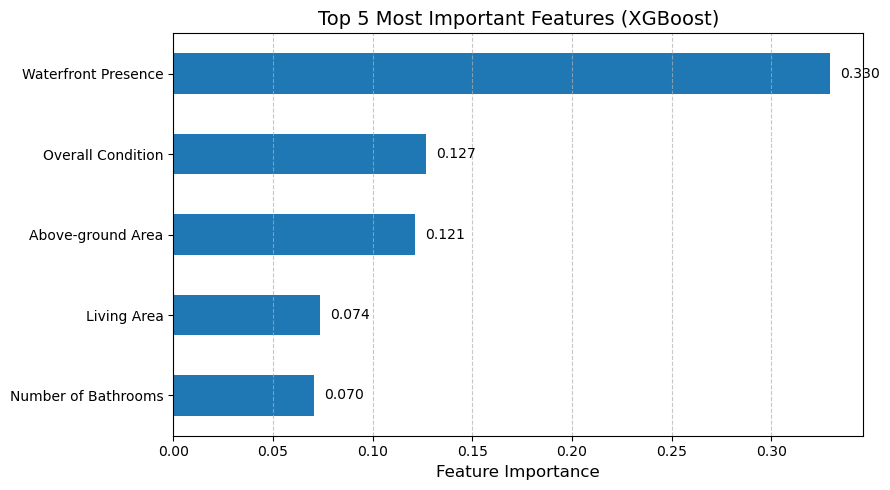

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

feature_name_map = {
    'waterfront': 'Waterfront Presence',
    'condition': 'Overall Condition',
    'sqft_above': 'Above-ground Area',
    'sqft_living': 'Living Area',
    'bathrooms': 'Number of Bathrooms'
}

raw_top5 = pd.Series({
    'waterfront': 0.329643,
    'condition': 0.126880,
    'sqft_above': 0.121389,
    'sqft_living': 0.073791,
    'bathrooms': 0.070444
})
top5_features = raw_top5.rename(index=feature_name_map)

plt.figure(figsize=(9, 5))
ax = top5_features.sort_values().plot(kind='barh', color=["#1f77b4"])

for i, value in enumerate(top5_features.sort_values()):
    plt.text(value + 0.005, i, f"{value:.3f}", va='center')

plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 5 Most Important Features (XGBoost)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Comparison

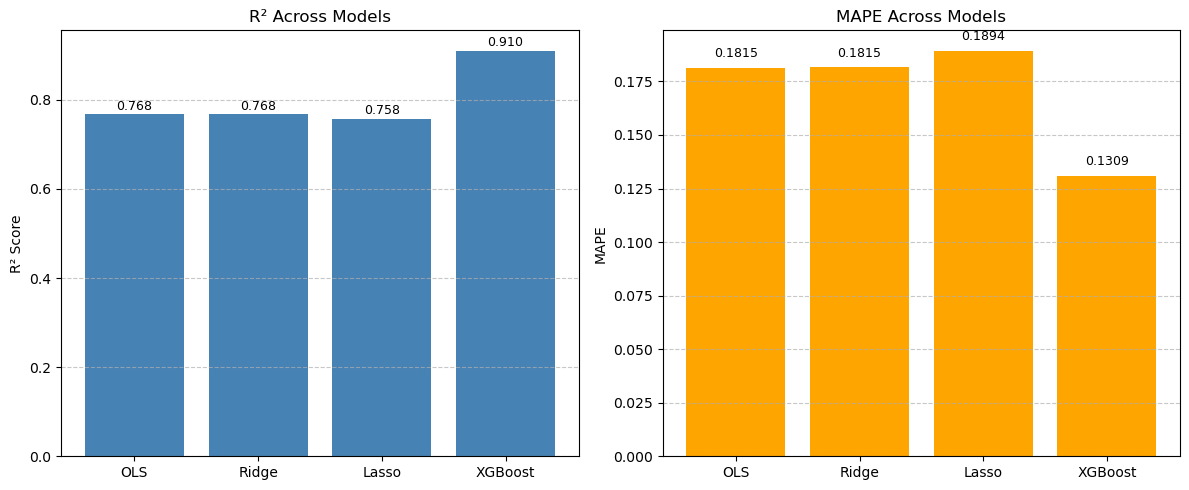

In [73]:
# Plot R² and MAPE in two separate bar charts with only two colors
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define colors
color_r2 = 'steelblue'
color_mape = 'orange'

# Define scores
scores = {
    'OLS': [ols_r2, ols_mape],
    'Ridge': [ridge_r2, ridge_mape],
    'Lasso': [lasso_r2, lasso_mape],
    'XGBoost': [r2_test, mape_test]
}

# Model names
model_names = list(scores.keys())

# R² bar plot
r2_values = [scores[model][0] for model in model_names]
axes[0].bar(model_names, r2_values, color=color_r2)
for i, v in enumerate(r2_values):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
axes[0].set_title("R² Across Models")
axes[0].set_ylabel("R² Score")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# MAPE bar plot
mape_values = [scores[model][1] for model in model_names]
axes[1].bar(model_names, mape_values, color=color_mape)
for i, v in enumerate(mape_values):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
axes[1].set_title("MAPE Across Models")
axes[1].set_ylabel("MAPE")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


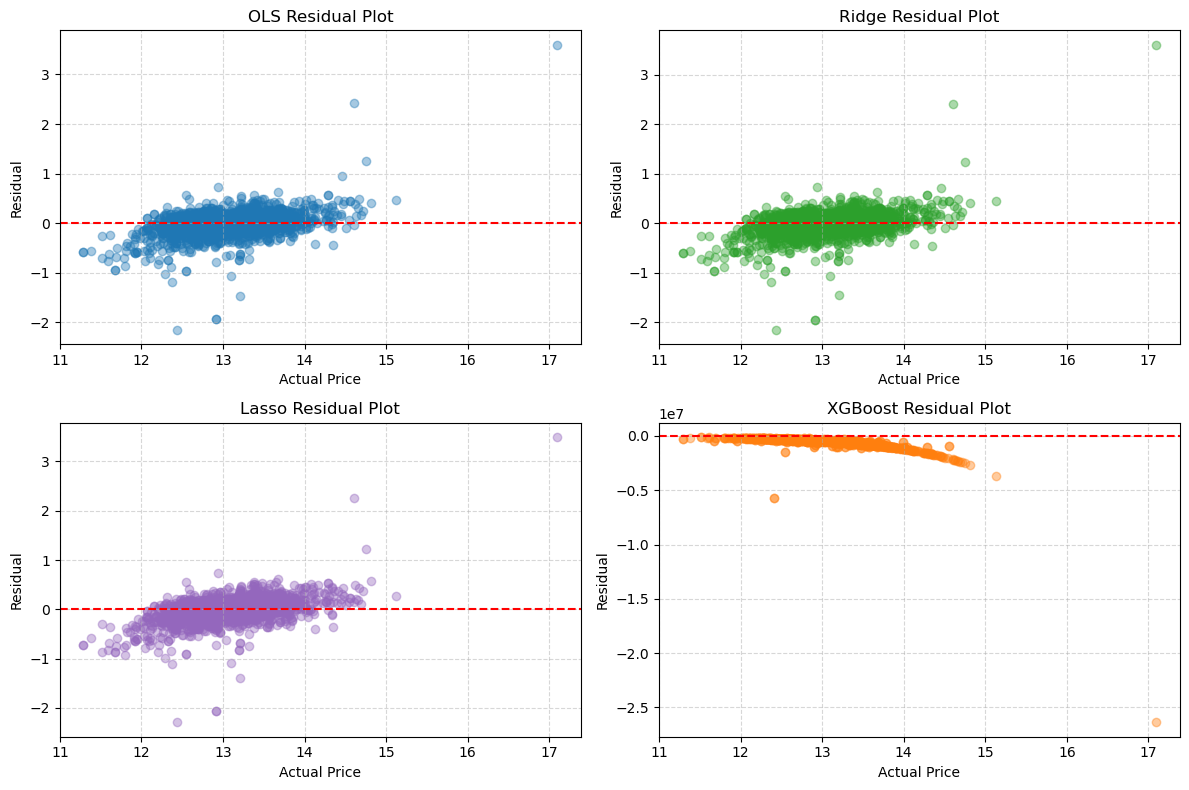

In [75]:
import matplotlib.pyplot as plt

colors = {
    'OLS': '#1f77b4',     
    'Ridge': '#2ca02c',    
    'Lasso': '#9467bd',    
    'XGBoost': '#ff7f0e'   
}

residuals = {
    'OLS': y_test - ols_preds,
    'Ridge': y_test - ridge_preds,
    'Lasso': y_test - lasso_preds,
    'XGBoost': y_test - y_pred_xgb
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, (model, res) in enumerate(residuals.items()):
    ax = axes[i // 2, i % 2]
    ax.scatter(y_test, res, alpha=0.4, color=colors[model])
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f"{model} Residual Plot")
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Residual")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


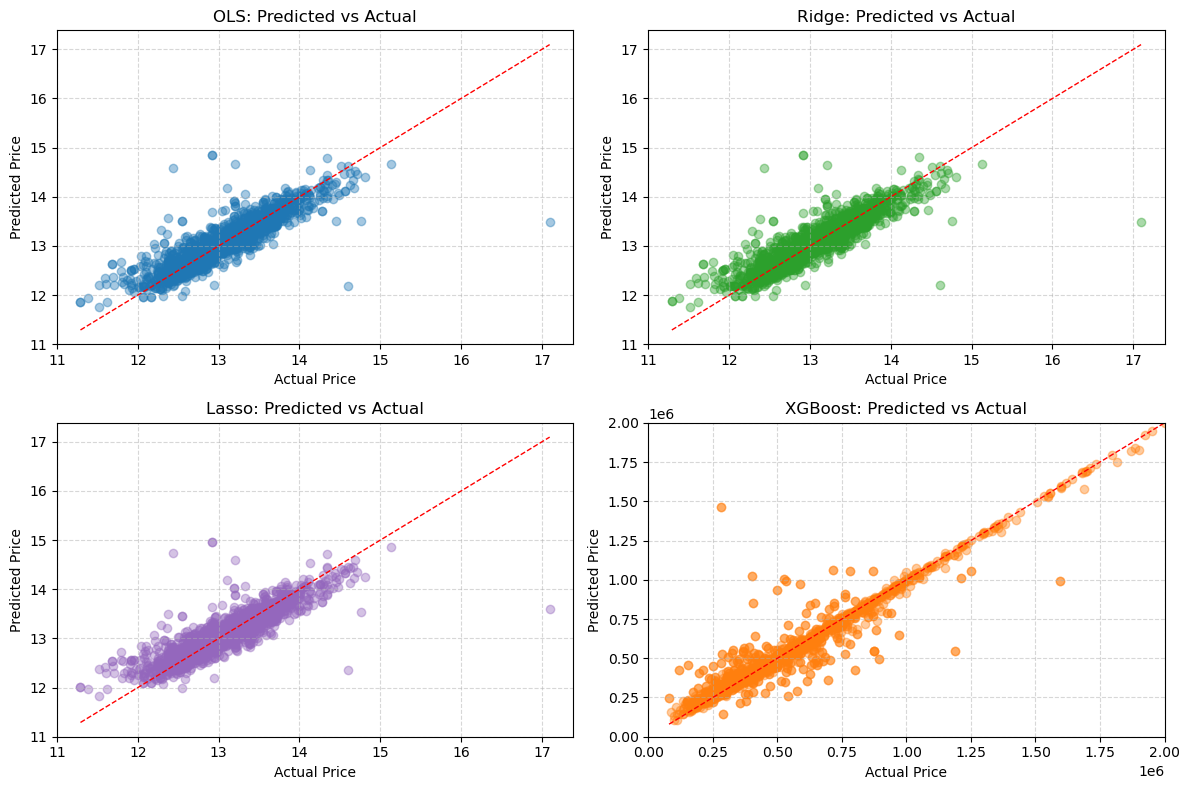

In [76]:
import matplotlib.pyplot as plt

colors = {
    'OLS': '#1f77b4',
    'Ridge': '#2ca02c',
    'Lasso': '#9467bd',
    'XGBoost': '#ff7f0e'
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

predictions = {
    'OLS': (y_test, ols_preds),
    'Ridge': (y_test, ridge_preds),
    'Lasso': (y_test, lasso_preds),
    'XGBoost': (y_test_xgb, y_pred_xgb)
}

for i, (model, (actual, pred)) in enumerate(predictions.items()):
    ax = axes[i // 2, i % 2]
    ax.scatter(actual, pred, alpha=0.4, color=colors[model])
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=1)
    ax.set_title(f"{model}: Predicted vs Actual")
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Predicted Price")
    ax.grid(True, linestyle='--', alpha=0.5)

    if model == 'XGBoost':
        ax.set_xlim(0, 2e6)
        ax.set_ylim(0, 2e6)

plt.tight_layout()
plt.show()


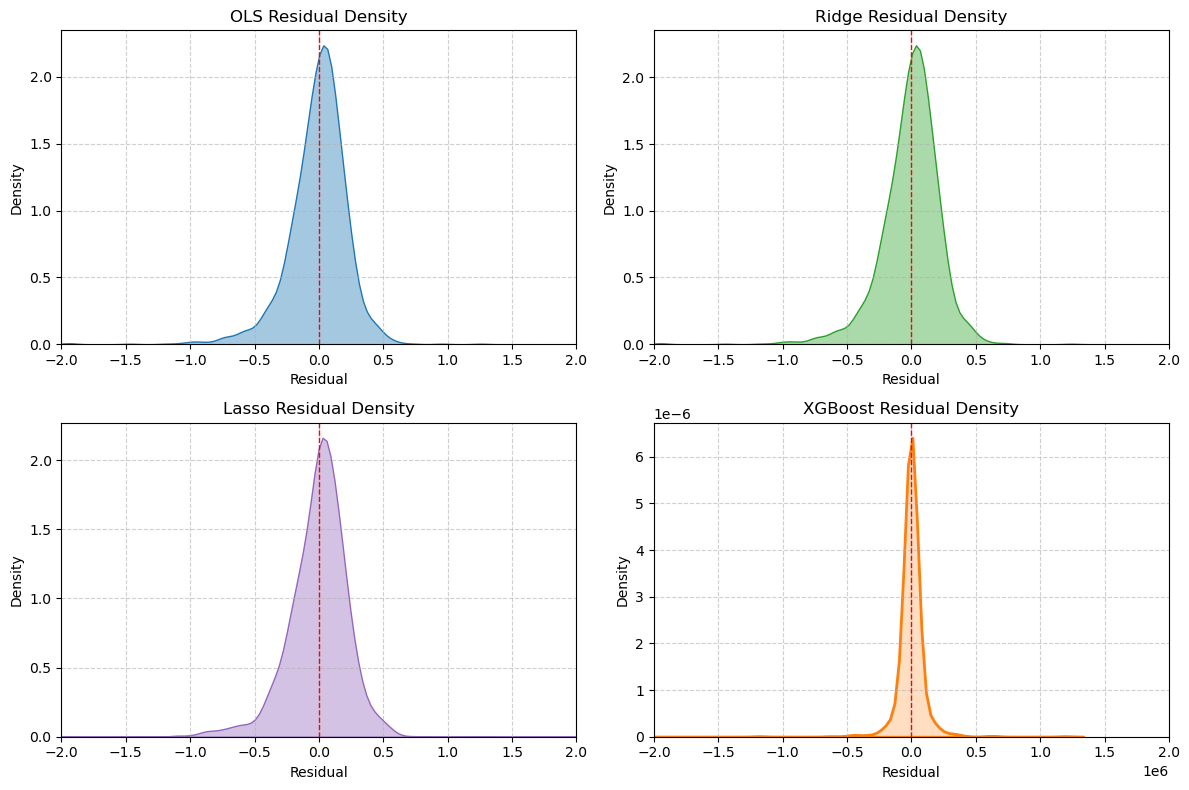

In [77]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

# 自定义颜色
colors = {
    'OLS': '#1f77b4',    
    'Ridge': '#2ca02c',  
    'Lasso': '#9467bd',  
    'XGBoost': '#ff7f0e'  
}

# 清理残差
cleaned_residuals = {}
for model, res in residuals.items():
    res = np.array(res)
    cleaned = res[np.isfinite(res)]
    cleaned_residuals[model] = cleaned

# XGBoost 残差使用新的绘图方式（你训练出的 y_test_xgb 和 y_pred_xgb）
residuals_xgb = y_test_xgb - y_pred_xgb  # 替代 residuals['XGBoost']

# 创建子图布局
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 循环绘图
for i, model in enumerate(['OLS', 'Ridge', 'Lasso', 'XGBoost']):
    ax = axes[i // 2, i % 2]
    
    if model != 'XGBoost':
        sns.kdeplot(x=cleaned_residuals[model], ax=ax, fill=True, color=colors[model], alpha=0.4)
        ax.set_xlim(-2, 2)
    else:
        sns.kdeplot(x=residuals_xgb, ax=ax, fill=True, color=colors[model], linewidth=2)
        ax.set_xlim(-2e6, 2e6)

    ax.axvline(0, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"{model} Residual Density")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


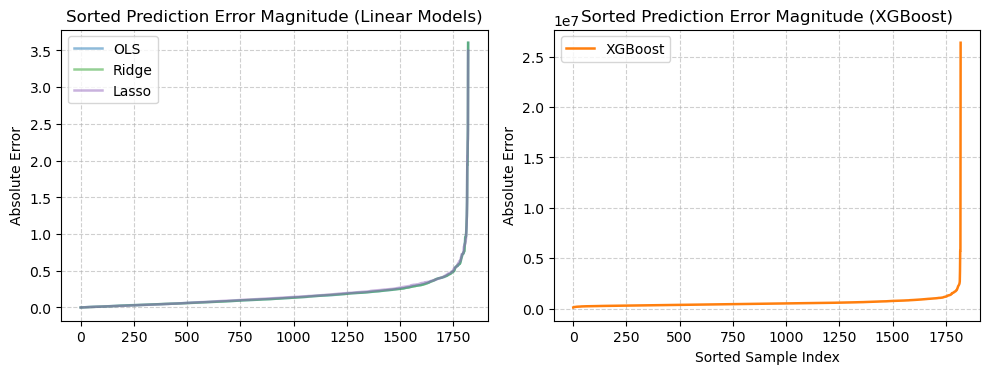

In [78]:
import matplotlib.pyplot as plt
import numpy as np

abs_errors_sorted = {
    model: np.sort(np.abs(residuals[model]))
    for model in ['OLS', 'Ridge', 'Lasso', 'XGBoost']
}

# 配色
colors = {
    'OLS': '#1f77b4',
    'Ridge': '#2ca02c',
    'Lasso': '#9467bd',
    'XGBoost': '#ff7f0e'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

for model in ['OLS', 'Ridge', 'Lasso']:
    axes[0].plot(abs_errors_sorted[model], label=model, color=colors[model], linewidth=1.8,alpha=0.5)
axes[0].set_title("Sorted Prediction Error Magnitude (Linear Models)")
axes[0].set_ylabel("Absolute Error")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(abs_errors_sorted['XGBoost'], label='XGBoost', color=colors['XGBoost'], linewidth=1.8)
axes[1].set_title("Sorted Prediction Error Magnitude (XGBoost)")
axes[1].set_xlabel("Sorted Sample Index")
axes[1].set_ylabel("Absolute Error")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


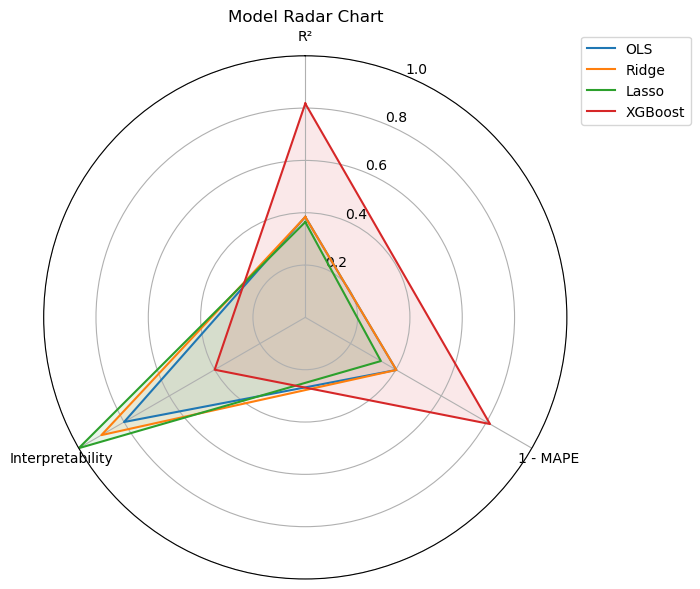

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'XGBoost'],
    'R2': [0.7242, 0.7241, 0.7160, 0.9140],
    'MAPE': [0.1815, 0.1815, 0.1894, 0.1309],
    'Interpretability': [4, 4.5, 5, 2]
})

# Z-score + Sigmoid
def zsig(series, reverse=False):
    z = (series - series.mean()) / series.std()
    if reverse:
        z = -z
    return 1 / (1 + np.exp(-z))

data['R2_norm'] = zsig(data['R2'])
data['MAPE_norm'] = zsig(data['MAPE'], reverse=True)
data['Interp_norm'] = data['Interpretability'] / 5 

radar_data = data[['Model', 'R2_norm', 'MAPE_norm','Interp_norm']].set_index('Model')
categories = ['R²', '1 - MAPE', 'Interpretability']
labels = radar_data.columns
values = radar_data.values

num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values = np.concatenate((values, values[:, [0]]), axis=1)
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(polar=True))
for i, (model, row) in enumerate(radar_data.iterrows()):
    ax.plot(angles, row.tolist() + [row.tolist()[0]], label=model)
    ax.fill(angles, row.tolist() + [row.tolist()[0]], alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
ax.set_title("Model Radar Chart")
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()
